# Implementing a FIR filter on a FPGA
Lorenzo Borella, Marco Giunta, Samuele Pio Lipani

In [1]:
import numpy as np 
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt 
from numba import njit

# Loading the data

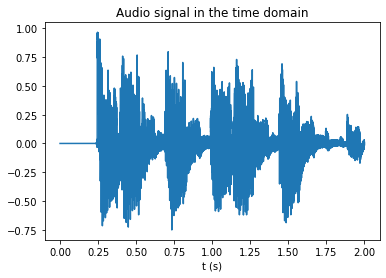

In [2]:
M = np.loadtxt("data/mario.txt", delimiter=",")
t = M[:,0]
x = M[:,1]
plt.plot(t,x)
plt.xlabel("t (s)")
plt.title("Audio signal in the time domain");

The interesting part of the signal (i.e. significantly non zero) starts at time 2693 s
We now extract a fraction of the signal which is 500 elements long starting from time 0.244185519336265


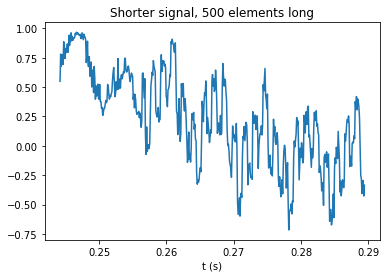

In [3]:
index_interesting_part = (np.nonzero(x > 0.25))[0][0] # np.nonzero returns a tuple of arrays, a double indexing is needed
i = index_interesting_part
print(f"The interesting part of the signal (i.e. significantly non zero) starts at time {i} s")

n_samples = 500
print(f"We now extract a fraction of the signal which is {n_samples} elements long starting from time {t[i]}")
x2 = x[i:i+n_samples]
t2 = t[i:i+n_samples]
plt.plot(t2,x2)
plt.title(f"Shorter signal, {n_samples} elements long")
plt.xlabel("t (s)");

In [4]:
def frequency_spectrum(t, x, fs = None) :
    if fs is None :
        fs = 1/(np.diff(t).mean())
    a = np.abs(np.fft.fft(x))*2/len(x)
    a = a[0:len(a)//2]
    f = np.linspace(0,fs//2,len(a)) # np.fft.fftfreq(len(x), 1/fs)[0:len(x)//2] is an equivalent alternative
    return [f,a]

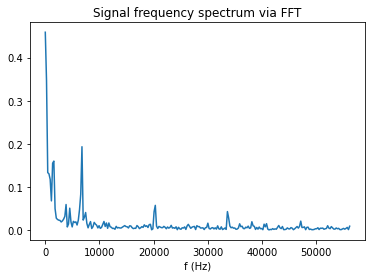

In [5]:
fs = 112500 # the song has been previously resampled to 112500 Hz via MATLAB

plt.plot(*frequency_spectrum(t2,x2,fs=fs))
plt.xlabel("f (Hz)")
plt.title("Signal frequency spectrum via FFT");

We now corrupt our input signal with 4 kHz sinusoidal noise.

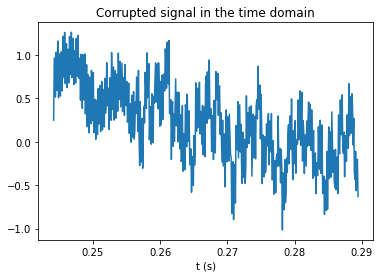

In [6]:
xc = x2 + 0.3*np.sin(2*np.pi*4000*t2)
plt.plot(t2,xc)
plt.xlabel("t (s)")
plt.title("Corrupted signal in the time domain");

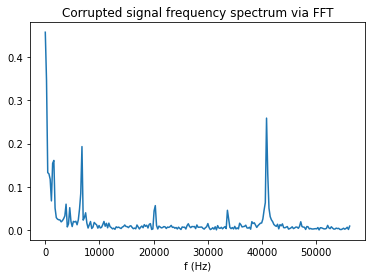

In [7]:
fs = 112500 # the song has been previously resampled to 112500 Hz via MATLAB

plt.plot(*frequency_spectrum(t2,xc,fs=fs))
plt.xlabel("f (Hz)")
plt.title("Corrupted signal frequency spectrum via FFT"); # notice the peak that appearead at 4 kHz

# FIR filter response as a function of $N_{\text{taps}}$ and $f_c$

Before proceeding any further let's graph the filter response in dB for some values of $N$ and $f_c$; this way we can decide which parameters to use for the FPGA implementation.

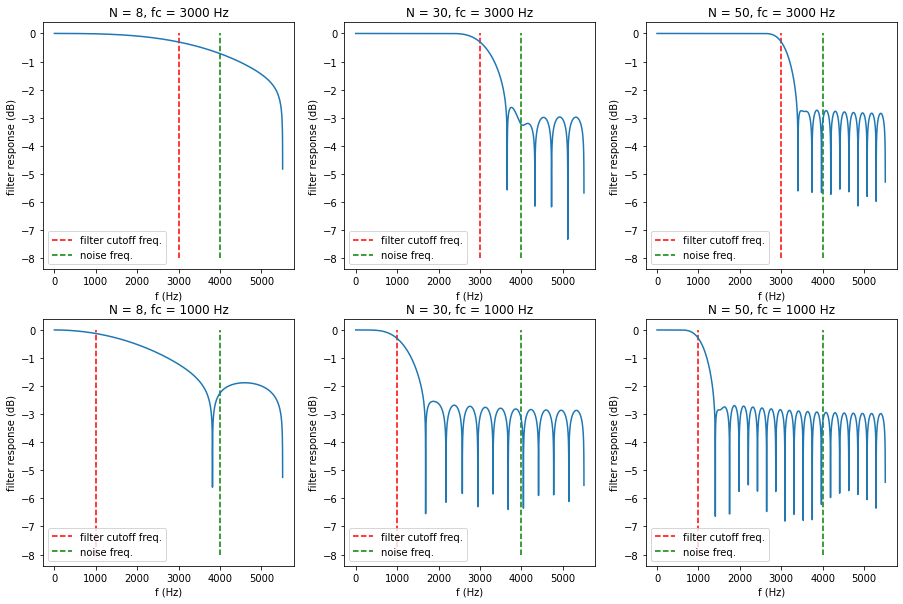

In [8]:
fs = 11025
#fc_list = [3000,1000]
#N_taps_list = [8,25]
l = [((0,0),3000,8), ((0,1),3000,30), ((0,2),3000,50), 
     ((1,0),1000,8), ((1,1),1000,30), ((1,2),1000,50)]

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (9*1.7, 5*2.0))

for j, fc, N in l :
    coeffs = firwin(numtaps = N, cutoff=fc, fs=fs, pass_zero="lowpass")
    #print(f"FIR coefficients for fc = {fc} Hz, N_taps = {N}: {coeffs}" + "\n")
    [w,h] = freqz(coeffs, worN=len(x)) # this evaluates the response of our filter in worN points
    w *= (fs/2)/np.pi # by default w is normalized to the [0,pi] interval; we map this to [0,f_nyq] 
    h = np.log10(np.abs(h)) # h is complex -> abs, we want to show the the y axis in dB -> log10
    ax[j].plot(w,h)
    ax[j].set_xlabel("f (Hz)")
    ax[j].set_ylabel("filter response (dB)")
    ax[j].vlines(x = fc, ymin = -8, ymax = 0, linestyle = "dashed", colors = "red", label = "filter cutoff freq.")
    ax[j].vlines(x = 4000, ymin = -8, ymax = 0, linestyle = "dashed", colors = "green", label = "noise freq.")
    ax[j].legend(loc = "lower left")
    ax[j].set_title(f"N = {N}, fc = {fc} Hz")

We notice performance improves as $N_{\text{taps}}$ and/or $f_c$ increase.

# Preparing the data for FPGA feeding

It's easy to show that if we apply the transformation $x\to k_{\text{data}}x, \ b \to k_{\text{coeff}}b$ at the beginning and its inverse after we applied the filter the result doesn't change due to the linearity of the filter. If, however, in between these operations we cast floats to int this procedure amounts to discarding a certain number of decimal figures (again: easy to see). Does this approximation affect the result? Let's compute the simulated output with and without this approximation.

126


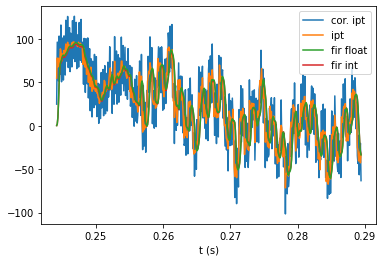

In [9]:
k_data = 100
k_coeff = 467

fs = 11025
fc = 1000 
N_taps = 8
N = N_taps
coeffs = firwin(numtaps=N_taps, cutoff=fc, fs=fs, pass_zero="lowpass")
coeffs_int = (k_coeff*coeffs).astype(int)

print(np.abs((100*xc).astype(int)).max()) # we're still inside 7 effective bits

@njit # otherwise the filter is a bit slow
def fir_int(input, coeffs_int, Nt) :
    output_int = np.zeros(input.shape[0])
    for n in range(7, len(output_int)) :
        for i in range(Nt) :
            output_int[n] += int(coeffs_int[i]*input[n-i])
    return output_int


@njit
def fir_float(input, coeffs, Nt) :
    output_float = np.zeros(input.shape[0])
    for n in range(7, len(output_float)) :
        for i in range(Nt) :
            output_float[n] += coeffs[i]*input[n-i]
    return output_float


y_int = np.hstack((np.zeros((7,)),k_data*xc)).astype(int) # 7 è N-1

output_int = fir_int(y_int, coeffs_int, N)

output_int = output_int[7:] # we discard the first 7 values

output_int /= k_coeff
#output_int /= k_data
#print(output_int)

y_float = np.hstack((np.zeros((7,)),k_data*xc))
output_float = fir_float(y_float, coeffs, N)
output_float = output_float[7:]
#output_float /= k_data
#print(output_float)

plt.plot(t2,k_data*xc, label="cor. ipt",zorder=1);
plt.plot(t2,x2*k_data,label="ipt",zorder=2);
plt.plot(t2,output_float,label="fir float",zorder=4);
plt.plot(t2,output_int,label="fir int",zorder=3);
plt.xlabel("t (s)");
plt.legend(loc="upper right");



# data to send to the FPGA
y = np.hstack((np.zeros(7), xc, np.zeros(10))) # we pad some zeros to clean the pipeline

with open("input.txt","w") as fh :
    if False :
        np.savetxt(fh, (y*k_data).astype(int), fmt="%d")

Notice the float and int version of the filter return indistinguishable outputs.

# Loading FPGA data

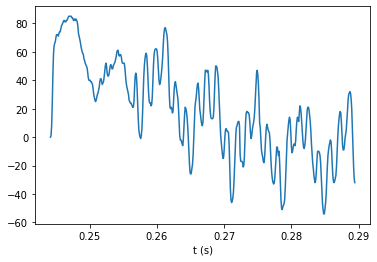

In [10]:
z = np.loadtxt("data/fpga_output_definitivo.txt")
plt.plot(t2[:z.shape[0]],z);
plt.xlabel("t (s)");

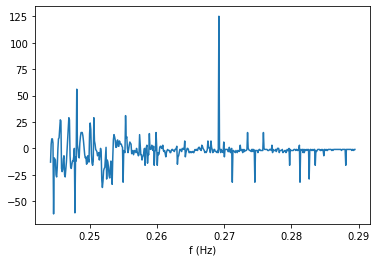

In [11]:
# What goes wrong if we choose the wrong bits?
# discard first 7 and last 10 values
plt.plot(t2,np.loadtxt("fpga_brutto.txt")[7:-10])
plt.xlabel("f (Hz)");

# FPGA - simulation comparison

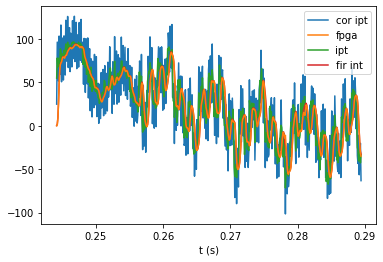

In [12]:
# time domain
K = 2**9/k_coeff

plt.plot(t2,k_data*xc, label="cor ipt",zorder=1);
plt.plot(t2[:z.shape[0]],z*K,label="fpga",zorder=4);
plt.plot(t2,x2*k_data,label="ipt",zorder=2);
plt.plot(t2,output_int,label="fir int",zorder=3);
plt.xlabel("t (s)")
plt.legend(loc="upper right");

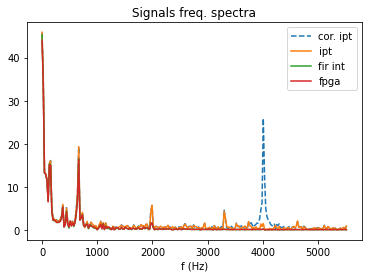

In [13]:
# frequency domain
[f,ac] = frequency_spectrum(t2, xc*k_data, fs = fs)
[_,ax] = frequency_spectrum(t2, x2*k_data, fs = fs)
[_,ao] = frequency_spectrum(t2, output_int, fs = fs)
[_,af] = frequency_spectrum(t2, z*K, fs = fs)

plt.plot(f,ac,"--",label="cor. ipt",zorder=1)
plt.plot(f,ax,label="ipt",zorder=2)
plt.plot(f,ao,label="fir int",zorder=3)
plt.plot(f,af,label="fpga",zorder=4)

plt.xlabel("f (Hz)")
plt.title("Signals freq. spectra")
plt.legend(loc="upper right");